In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 

### Load Feature & Test
- time-series.npy : by cols-window
- tpc-name.npy : by rows
- tpc-feature.npy : by rows
- tpc-raw-length : by rows
- df : by rows and cols 

In [19]:
df = pd.read_csv('train_1.csv')
df = df[ df.columns[ df.columns!='Page']].fillna(0)
tpc_name = np.load('tpc_name.npy')
tpc_feature = np.load('tpc_feature.npy', mmap_mode='r')
raw_leng = np.load('tpc_raw_leng.npy', mmap_mode='r')

### Check Data 

In [16]:
def test(name):
    s = np.load(name)
    print (s[1], s[2], s.shape)

test('tpc_name.npy')
print (df.head())

[40444, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [1836, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (145063,)
   2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  \
0        18.0        11.0         5.0        13.0        14.0         9.0   
1        11.0        14.0        15.0        18.0        11.0        13.0   
2         1.0         0.0         1.0         1.0         0.0         4.0   
3        35.0        13.0        10.0        94.0         4.0        26.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   2015-07-07  2015-07-08  2015-07-09  2015-07-10     ...      2016-12-22  \
0         9.0        22.0        26.0        24.0     ...            32.0   
1        22.0        11.0        10.0         4.0     ...            17.0   
2         0.0         3.0         4.0         4.0     ...             3.0   


In [17]:
from data_generator import gen_data

In [20]:
hpara = {'his_window':10,
         'gap':10,
         'predict_window': 10,
         'df': df,  
         'tpc_name':tpc_name, 
         'tpc_feature':tpc_feature,
         'raw_leng': raw_leng, 
         'batch_size':2, 
         'verbose':1}
    
X, dateTime, tpcName, tpcFeature, rawLeng, truY = gen_data(**hpara)

[(20,), (100,), (70,), (8,), (2,), (20,)]


### Model Architecture 
- nlp model 
- time-series-emb
- LSTM & CNN
- Dense 
- loss = sequence rmse

In [50]:
def embdding_ly(name, hidded_dims, input_id):
    '''embdding 2D matrix, 1D input '''
    assert hidded_dims > self.col_set_dim
    emb = tf.get_variable(name, shape=(self.col_set_dim, hidded_dims))
    return tf.nn.embedding_lookup(emb, input_id)

def sequence_rmse(y, y_hat, sequence_lengths, max_sequence_length):
    y = tf.cast(y, tf.float32)
    squared_error = tf.square(y - y_hat)
    # because output is a sequence but input sequence is padded 
    sequence_mask = tf.cast(
        tf.sequence_mask(sequence_lengths, maxlen=max_sequence_length),
                    tf.float32)

    avg_squared_error = tf.reduce_sum(squared_error*sequence_mask) / tf.cast(
        tf.reduce_sum(sequence_lengths), tf.float32)
    return tf.sqrt(avg_squared_error)

def log_seq_rmse(y, y_hat, sequence_lengths, max_sequence_length):
    y = tf.cast(y, tf.float32)
    squared_error = tf.square(y - y_hat)
    # because output is a sequence but input sequence is padded 
    sequence_mask = tf.cast(
        tf.sequence_mask(sequence_lengths, maxlen=max_sequence_length),
                    tf.float32)

    avg_squared_error = tf.reduce_sum(squared_error*sequence_mask) / tf.cast(
        tf.reduce_sum(sequence_lengths), tf.float32)
    return tf.log(tf.sqrt(avg_squared_error))


def build_model(a, b, c):
    c = tf.concat([a,b,c], axis=1)
    c = tf.expand_dims(c, axis=2)
    #c = tf.expand_dims(c,2)
    #c = tf.reshape(c, shape=(2,1,39))
    c = tf.contrib.keras.layers.LSTM(100, input_shape=(4,1))(c)
    c = tf.contrib.keras.layers.Dense(55)(c)
    c = tf.nn.sigmoid(c)
    c = tf.contrib.keras.layers.Dense(32)(c)
    c = tf.nn.sigmoid(c)
    c = tf.contrib.keras.layers.Dense(hpara['predict_window'])(c)
    #c = lstm_layer(c, lengths=[2], state_size=24, reuse=True)
    return c

In [51]:

a,b,c,d,e, f =  gen_data(**hpara)

PLD = tf.placeholder
p_X          = PLD(tf.float32, [None, hpara['his_window']])
p_dateTime   = PLD(tf.float32, [None, 5*hpara['his_window']])
p_tpcName    = PLD(tf.float32, [None, 35])
p_tpcFeature = PLD(tf.float32, [None, 4])
p_rawLeng    = PLD(tf.float32, [None, 1])
p_truY       = PLD(tf.float32, [None, hpara['his_window']])

feed_dict = {
    p_X          : a,
    p_dateTime   : b,
    p_tpcName    : c,
    p_tpcFeature : d,
    p_rawLeng    : e,
    p_truY       : f,
}

out = build_model(p_X, p_dateTime, p_tpcFeature)
loss_op = log_seq_rmse(p_truY, out, 
                        sequence_lengths=[hpara['predict_window']],
                        max_sequence_length=hpara['predict_window'])
train_op = tf.train.AdamOptimizer().minimize(loss_op)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #c = sess.run(lstm_layer(pld_b, [2], 3),  feed_dict={ pld_a:a, pld_b:b })
    #c = sess.run(out, feed_dict={ pld_a:a, pld_b:b, pld_c:c })
    lo, _ = sess.run([loss_op, train_op], feed_dict=feed_dict)
    print (lo)

[(20,), (100,), (70,), (8,), (2,), (20,)]
7.33767


In [46]:
x = [ i*i for i in range(10)]
y = np.log(x)
%matplotlib inline


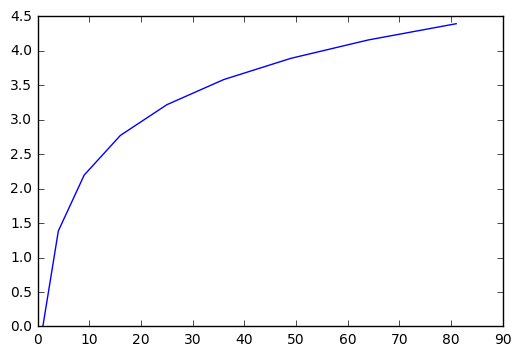

In [47]:
import matplotlib.pyplot as plt 
plt.plot(x,y)